# Example: Cargo flow plots 

This example demonstrates the workflow to import (persisted Vessels DB) and call (VoyagesAPI) the required data in order to replicate the cargo flow visualizations of either imports or exports from a specific load area and of a specific vessel class.

In [1]:
signal_ocean_api_key = '...' #replace with your subscription key

In [197]:
from signal_ocean import Connection
import pandas as pd
from datetime import date, timedelta, timezone

connection = Connection(signal_ocean_api_key)

## 1. Importing the data

### 1.1. Calling VoyagesAPI:

In [198]:
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.distances import DistancesAPI, VesselClassFilter

In [75]:
# Specify call parameters

area_of_interest = 'Australia West'
vessel_class = 'Capesize'                
date_from = date(2018,12,31)         # start_date_from
activity = 'export'                  # "import" or "export"

In [4]:
# Call VoyagesAPI() utilising DistancesAPI() filter

voyages_api = VoyagesAPI(connection)
distances_api = DistancesAPI(connection)

vessel_class_id = distances_api.get_vessel_classes(VesselClassFilter(name_like=vessel_class))[0].id  # extract vessel class id

voyages = voyages_api.get_voyages(vessel_class_id=vessel_class_id, date_from=date_from - timedelta(months=3)) # Feature Note: specify date column to use for date_from (i.e first_load_arrival_date). Temp fix: Since we are interested in first_load_arrival_date and not start_date, subtract 3 months from date_from to ensure all data-of-interest are included.
voyages = pd.DataFrame(v.__dict__ for v in voyages)

events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)

In [13]:
# Append neccessary cargo flow events

def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

In [29]:
# Filter voyages by "imports" or "exports"

def get_voyage_imports_exports(voyages, activity):
    if activity == 'export':
        return voyages[(voyages['load_area']==area_of_interest)&(voyages['discharge_country']!=area_of_interest)]
    elif activity == 'import':
        return voyages[(voyages['discharge_country']==area_of_interest)&(voyages['load_area']!=area_of_interest)]
    else:
        raise SyntaxError('activity must take values "import" or "export".')
        
voyages = get_voyage_imports_exports(voyages, activity)

In [20]:
# Clean any predicted data and keep only current/historical

voyages = voyages[pd.to_datetime(voyages['first_load_arrival_date']) <= datetime.now(tz=timezone.utc)]
voyages

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,vessel_name,...,fixture_date,fixture_is_coa,fixture_is_hold,is_implied_by_ais,has_manual_entries,ballast_distance,laden_distance,load_area,load_country,discharge_country
115,9165322,68,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED41A3F00', port_id=8...",I8BDA0AVED41A3F00,Great Sunrise,...,NaT,None,None,None,None,3568.06,3721.32,Australia West,Australia,Japan
116,9165322,69,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4695900', port_id=8...",I8BDA0AVED4695900,Great Sunrise,...,NaT,None,None,None,None,3559.00,3699.87,Australia West,Australia,Japan
117,9165322,70,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED4B87300', port_id=8...",I8BDA0AVED4B87300,Great Sunrise,...,NaT,None,None,None,None,3567.84,3639.62,Australia West,Australia,Japan
121,9165322,74,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6930F00', port_id=8...",I8BDA0AVED6930F00,Great Sunrise,...,NaT,None,None,None,None,3537.96,3562.22,Australia West,Australia,Japan
122,9165322,75,3,70,1,3814,False,"(VoyageEvent(id='I8BDA0ASED6E22900', port_id=8...",I8BDA0AVED6E22900,Great Sunrise,...,NaT,None,None,None,None,3565.06,3601.37,Australia West,Australia,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20714,9889306,1,3,70,1,-1,False,"(VoyageEvent(id='I96E61ASED7805D00', port_id=6...",I96E61AVED7805D00,Azul Tierra,...,NaT,None,None,None,None,3538.00,3990.98,Australia West,Australia,Japan
20715,9889306,2,3,70,1,-1,False,"(VoyageEvent(id='I96E61ASED7CF7700', port_id=8...",I96E61AVED7CF7700,Azul Tierra,...,NaT,None,None,None,None,3476.59,3597.32,Australia West,Australia,Japan
20719,9891907,1,3,70,1,-1,False,"(VoyageEvent(id='I96F043SED7A7EA00', port_id=6...",I96F043VED7A7EA00,Southern Cross,...,NaT,None,None,None,None,3647.09,3751.90,Australia West,Australia,Japan
20720,9891907,2,3,70,1,-1,False,"(VoyageEvent(id='I96F043SED7F70400', port_id=3...",I96F043VED7F70400,Southern Cross,...,NaT,None,None,None,None,3579.16,3812.28,Australia West,Australia,Japan


### 1.2. Import Persisted Vessel data:

In [28]:
import sqlite3

db_conn = sqlite3.connect('AllVessels.db')

query = db_conn.execute("SELECT imo,deadweight FROM Vessels") # extract only imo, deadweight columns
cols = [column[0] for column in query.description]
vessels = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)

db_conn.close()

vessels

,imo,deadweight
0,-2,0
1,-1,0
2,2228228,20420
3,5000172,269
4,5000201,590
...,...,...
43386,9920411,60000
43387,9922067,2874
43388,9922859,4820
43389,9922861,4820


### 1.3. Merge Voyage & Vessel data:

In [92]:
# Merge data and keep only useful info

voyages_merged = voyages.merge(vessels, on='imo')
voyages_merged = voyages_merged[['first_load_arrival_date','imo','voyage_number','deadweight','load_area','load_country','discharge_country']].sort_values('first_load_arrival_date').reset_index(drop=True)

voyages_merged.dtypes

first_load_arrival_date    datetime64[ns, UTC]
imo                                      int64
voyage_number                            int64
deadweight                               int64
load_area                               object
load_country                            object
discharge_country                       object
dtype: object

## 2. Plotting the data

In [109]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 2.1. Plot: Volume per Week

In [105]:
# Create bins of weeks-of-interest

dates = pd.date_range(start=date_from, end=date.today(), freq='W-MON', tz='UTC') # time-beggining

weeks_from_monday = pd.DataFrame(dates, columns=['first_load_arrival_date'])

weeks_from_monday

,first_load_arrival_date
0,2018-12-31 00:00:00+00:00
1,2019-01-07 00:00:00+00:00
2,2019-01-14 00:00:00+00:00
3,2019-01-21 00:00:00+00:00
4,2019-01-28 00:00:00+00:00
...,...
121,2021-04-26 00:00:00+00:00
122,2021-05-03 00:00:00+00:00
123,2021-05-10 00:00:00+00:00
124,2021-05-17 00:00:00+00:00


In [106]:
# Group voyages into weekly bins (starting from Monday) and aggregate(SUM)

volume_per_week = voyages_merged[['first_load_arrival_date', 'deadweight']].groupby(pd.Grouper(key='first_load_arrival_date', freq='W-MON', closed='right')).sum().reset_index()

volume_per_week

,first_load_arrival_date,deadweight
0,2018-12-10 00:00:00+00:00,361220
1,2018-12-17 00:00:00+00:00,8533497
2,2018-12-24 00:00:00+00:00,14678866
3,2018-12-31 00:00:00+00:00,14637893
4,2019-01-07 00:00:00+00:00,11497005
...,...,...
125,2021-05-03 00:00:00+00:00,17245724
126,2021-05-10 00:00:00+00:00,11891795
127,2021-05-17 00:00:00+00:00,16280350
128,2021-05-24 00:00:00+00:00,12175415


In [107]:
volume_per_week = weeks_from_monday.merge(volume_per_week, how='left', on='first_load_arrival_date')
volume_per_week['deadweight'] /= 1e6 # in million tonnes

volume_per_week

,first_load_arrival_date,deadweight
0,2018-12-31 00:00:00+00:00,14.637893
1,2019-01-07 00:00:00+00:00,11.497005
2,2019-01-14 00:00:00+00:00,11.147890
3,2019-01-21 00:00:00+00:00,14.540733
4,2019-01-28 00:00:00+00:00,11.729516
...,...,...
121,2021-04-26 00:00:00+00:00,15.185321
122,2021-05-03 00:00:00+00:00,17.245724
123,2021-05-10 00:00:00+00:00,11.891795
124,2021-05-17 00:00:00+00:00,16.280350


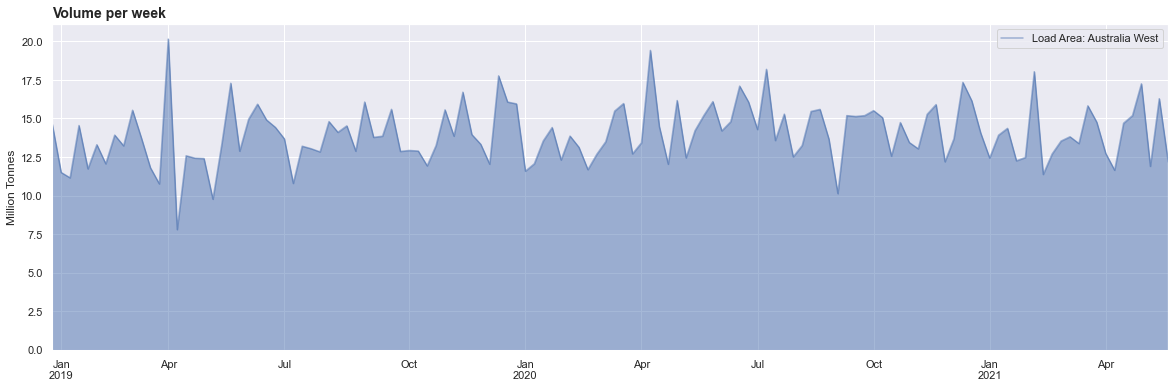

In [156]:
# https://matplotlib.org/stable/api/axes_api.html
fig, axs = plt.subplots(figsize=(20,6))

ax = volume_per_week.plot( ax=axs, x='first_load_arrival_date', y='deadweight', kind ='area', stacked=False, xlabel='', ylabel='Million Tonnes')

# Properties
axs.set_title('Volume per week',  fontsize=14, fontweight='bold', loc='left',)
axs.legend([f'Load Area: {area_of_interest}'])
#fmt_month = mdates.MonthLocator(interval=1)
#axs.xaxis.set_major_locator(fmt_month)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %Y'))
#axs.set_xticks(pd.date_range(start=, end=date.today(), freq='M'))

### 2.2. Plot: Countries of Destination

In [149]:
# Filter voyages by date
date_from = date(2021,1,1)  # SPECIFY new starting date

countries_of_destination = voyages_merged.loc[voyages_merged['first_load_arrival_date'].dt.date >= date_from].reset_index(drop=True)
countries_of_destination

,first_load_arrival_date,imo,voyage_number,deadweight,load_area,load_country,discharge_country
0,2021-01-01 03:59:25+00:00,9511349,48,176967,Australia West,Australia,China
1,2021-01-01 03:59:29+00:00,9736951,36,182651,Australia West,Australia,China
2,2021-01-01 03:59:51+00:00,9637791,75,180355,Australia West,Australia,China
3,2021-01-01 07:59:35+00:00,9713052,30,209067,Australia West,Australia,China
4,2021-01-01 11:54:31+00:00,9757175,27,208013,Australia West,Australia,China
...,...,...,...,...,...,...,...
1551,2021-05-28 08:39:15.049000+00:00,9735177,29,209475,Australia West,Australia,China
1552,2021-05-28 08:53:05.739000+00:00,9641895,58,181392,Australia West,Australia,China
1553,2021-05-28 09:01:39.496000+00:00,9738155,23,178438,Australia West,Australia,China
1554,2021-05-28 09:33:57.309000+00:00,9860958,6,209199,Australia West,Australia,China


In [154]:
# Group merged voyages by discharge country

countries_of_destination = voyages_merged.groupby(pd.Grouper(key='discharge_country')).sum().reset_index().sort_values('deadweight', ascending=True).reset_index(drop=True)
countries_of_destination['%_deadweight'] = 100*countries_of_destination['deadweight']/countries_of_destination['deadweight'].sum()

countries_of_destination

,discharge_country,imo,voyage_number,deadweight,%_deadweight
0,New Zealand,9461269,55,169092,0.009429
1,Singapore,9398711,59,170022,0.009481
2,Turkey,9363015,59,177987,0.009925
3,United Arab Emirates,9834129,7,186000,0.010372
4,United Kingdom,18940325,94,358230,0.019976
5,India,19452983,29,415572,0.023173
6,Netherlands,38192868,208,741670,0.041357
7,Malaysia,392356413,2196,7393670,0.412288
8,Australia,522196693,2835,9792702,0.546063
9,Indonesia,587597715,2575,11559739,0.644597


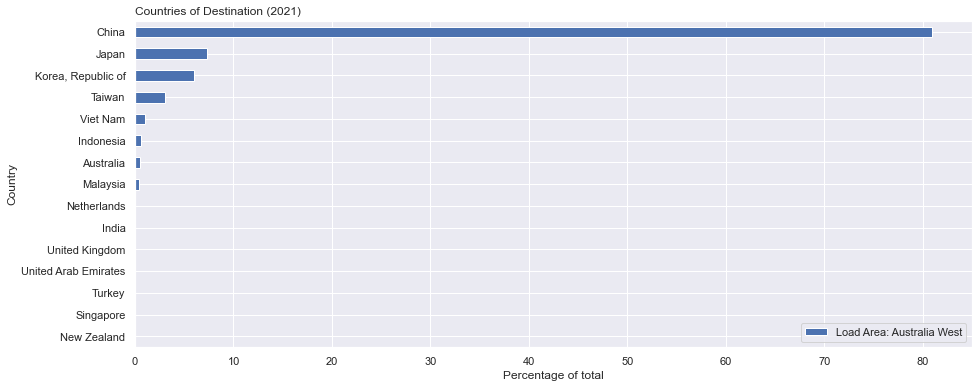

In [152]:
fig, axs = plt.subplots(figsize=(15,6))

countries_of_destination.plot.barh(ax=axs, y='%_deadweight', x='discharge_country')

# Properties
axs.set_title(f'Countries of Destination ({date_from.year})', loc='left')
axs.set_ylabel('Country')
axs.set_xlabel('Percentage of total')
axs.get_legend().remove()
axs.legend([f'Load Area: {area_of_interest}'], loc='lower right')

In [ ]:
# TODO: as far as plots are considered
# Volume per Week:
# - Make xticks tick monthly
# - Fix ylim to be 1.2-1.4*max(deadweight)

# Countries of Destination
# - Make xticks up to 100%
# - Add total cargo deadweight in each bar 

# Make both plots into a function (taking dataseries as inputs instead of dataframes(?))